In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

# import plotly.express as px
import os
import time
IMAGES_FOLDER_PATH = "../images"

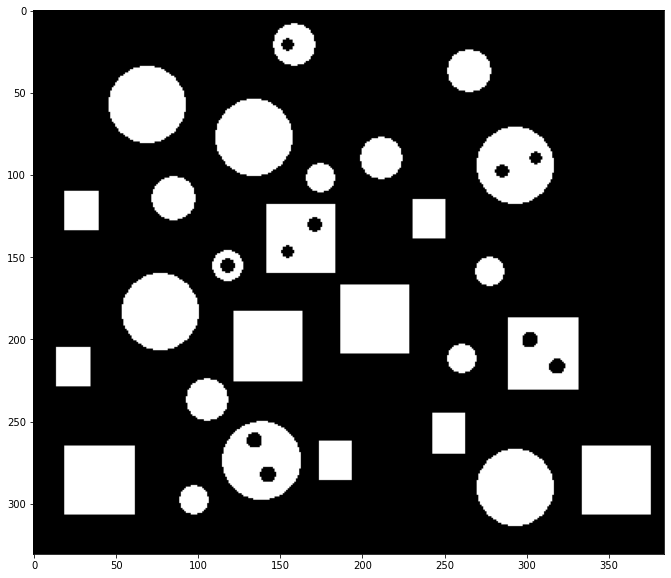

In [2]:
objects = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'objects.png'),0)
# plt.imshow(thumb,cmap='gray')
# plt.show()

ret,objects = cv2.threshold(objects,132,255,cv2.THRESH_BINARY)
plt.figure(figsize=(12,10))
plt.imshow(objects,cmap='gray')
plt.show()
objects = np.int64(objects/255)


## Part 1

In [3]:
def ccl_2_pass(img):
    h,w = img.shape
    labels = np.int64(np.zeros(img.shape))

    assoc = {}
    clr = 1
    if img[0,0] == 1:
        labels[0,0] = 1
        assoc[1] = -1
        clr = 2
            
    for j in range(1,w):
        if img[0,j] == 1:
            if img[0,j-1] == 1:
                labels[0,j] = labels[0,j-1]
            else:
                labels[0,j] = clr
                assoc[clr] = -1
                clr = clr + 1
                
    for i in range(1,h):
        for j in range(w):
            if img[i,j] == 1:
                prev_labels = []
                
                if labels[i-1,j]>0:
                    prev_labels.append(labels[i-1,j])
                
                if j > 1 :
                    if labels[i-1,j-1]>0:
                        prev_labels.append(labels[i-1,j-1])
                    if labels[i,j-1]>0:
                        prev_labels.append(labels[i,j-1])
                if (j+1) < w:
                    if labels[i-1,j+1]>0:
                        prev_labels.append(labels[i-1,j+1])

                if len(prev_labels) > 0:
                    prev_labels = np.array(prev_labels)
                    labels[i,j] = np.min(prev_labels)
                    for x in prev_labels:
                        if x != labels[i,j]:
                            assoc[x] = labels[i,j]
                else:
                    labels[i,j] = clr
                    assoc[clr] = -1
                    clr = clr +1
    for k,v in assoc.items():
        temp = v

        while(v!=-1 and assoc[temp] != -1):
            temp = assoc[temp]
        assoc[k] = temp
    
    for i in range(h):
        for j in range(w):
            if labels[i,j] and assoc[labels[i,j]]!=-1:
                labels[i,j] = assoc[labels[i,j]]

    return labels

In [4]:
labels = ccl_2_pass(objects)

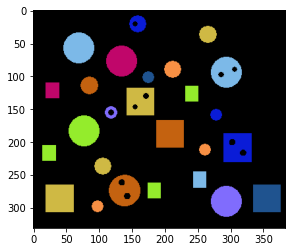

In [5]:
COLORS = [(0,0,0),(10, 28, 215), (248, 144, 68), (192, 6, 106), 
          (148, 236, 44), (207, 185, 68), (31, 83, 143), 
          (128, 108, 253), (124,185,232), (196,98,16)
         ]


output = np.zeros((objects.shape[0], objects.shape[1], 3))
for i in range(objects.shape[0]):
    for j in range(objects.shape[1]):
            output[i][j] = COLORS[int(labels[i,j] % 10)]

output = np.int64(output)
plt.imshow(output,cmap='gray')
plt.show()

In [6]:
num_objects = np.unique(labels).shape[0] - 1 
print("NUM OBJECTS",num_objects)
# print(np.unique(labels))

NUM OBJECTS 27


In [7]:
def get_object_with_holes(labels):
    num_objects = np.unique(labels).shape[0] -1
    colors = np.unique(labels)
    output = np.zeros(labels.shape)
    count = 0
    for i in range(1,num_objects):
        color = colors[i]
        obj = np.int64(labels == color)
        

        diff_labels = ccl_2_pass(1-obj)
        
        if np.unique(diff_labels).shape[0] > 2:
            count += 1
            output += obj
            
    return count,output

In [8]:
count,_ = get_object_with_holes(labels)
print("Images with holes :",count)

Images with holes : 6


## Part 2

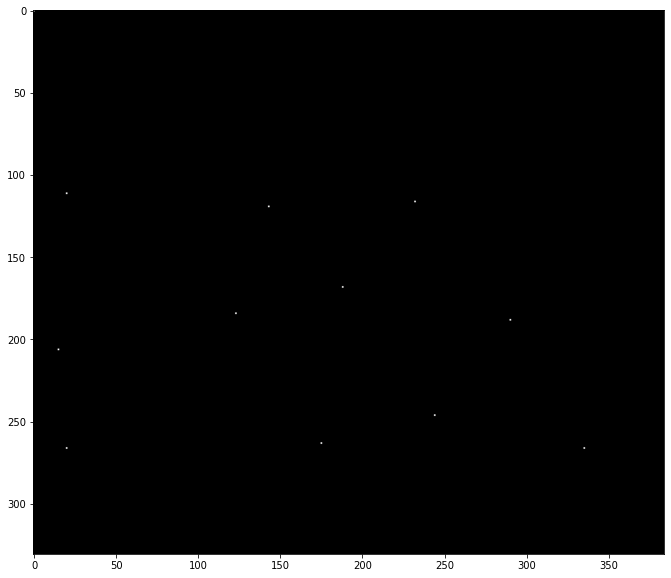

In [9]:
kernel = np.zeros((4,4),np.uint8)
for i in range(1, 4):
    kernel[1][i] = 1
    kernel[i][1] = 1

img = np.uint8(objects.copy())
# plt.figure(figsize=(12,10))
# plt.imshow(img,cmap='gray')
# plt.show()

eimg = cv2.erode(img, kernel, iterations = 1)
# plt.figure(figsize=(22,20))
# plt.imshow(abs(eimg - img),cmap='gray')
# plt.show()


squares_left_corners = np.int64(cv2.erode(abs(eimg - img), kernel, iterations = 1))
plt.figure(figsize=(12,10))
plt.imshow(squares_left_corners,cmap='gray')
plt.show()
squares_left_corners = np.int64(squares_left_corners/255)

In [10]:
labels = ccl_2_pass(squares_left_corners[1:,1:])
print("NUMBER OF SQUARES IS",np.unique(labels).shape[0]-1)

NUMBER OF SQUARES IS 11


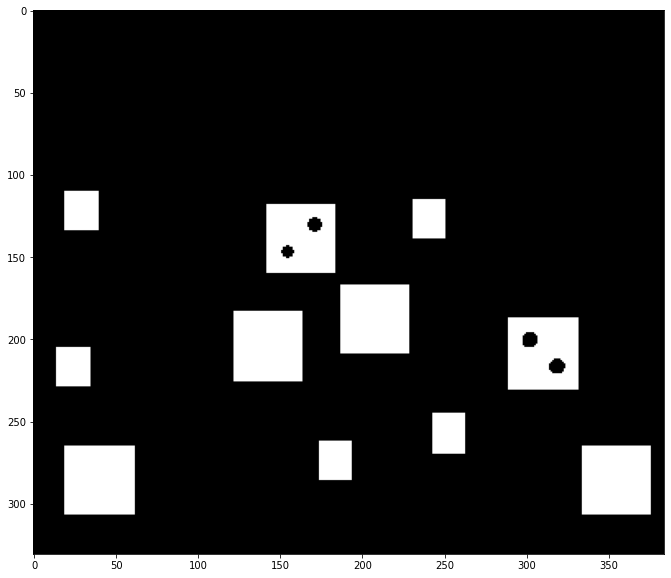

In [11]:
squares = np.zeros(objects.shape)
labels = np.zeros(objects.shape)

import sys
sys.setrecursionlimit(10000000)
def dfs(img,i,j,color):
    if i<0:
        return
    if j<0:
        return
    if i>=img.shape[0]:
        return
    if j>=img.shape[1]:
        return
    if squares[i,j]:
        return
    if img[i,j]==0:
        return
    
    labels[i,j] = color
    squares[i,j] = 1
    
    dfs(img,i-1,j-1,color)
    dfs(img,i-1,j,color)
    dfs(img,i-1,j+1,color)
    dfs(img,i+1,j-1,color)
    dfs(img,i+1,j+1,color)
    dfs(img,i+1,j,color)
    dfs(img,i,j+1,color)
    dfs(img,i,j,color)
    dfs(img,i,j-1,color)
    
    return labels 


for i in range(1,squares_left_corners.shape[0]):
    for j in range(1,squares_left_corners.shape[1]):
        if squares_left_corners[i,j]:
            dfs(objects,i,j,1)
plt.figure(figsize=(12,10))
plt.imshow(squares,cmap='gray')
plt.show()

## Part 3

In [12]:
square_components = ccl_2_pass(squares)
count,hole_squares = get_object_with_holes(square_components)
print("Squares  with holes :",count)

Squares  with holes : 2


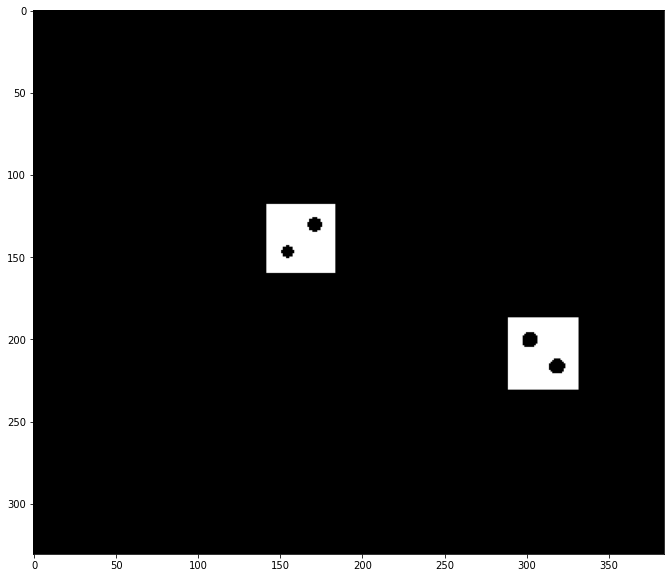

In [13]:
plt.figure(figsize=(12,10))
plt.imshow(hole_squares,cmap='gray')
plt.show()

## Part 4

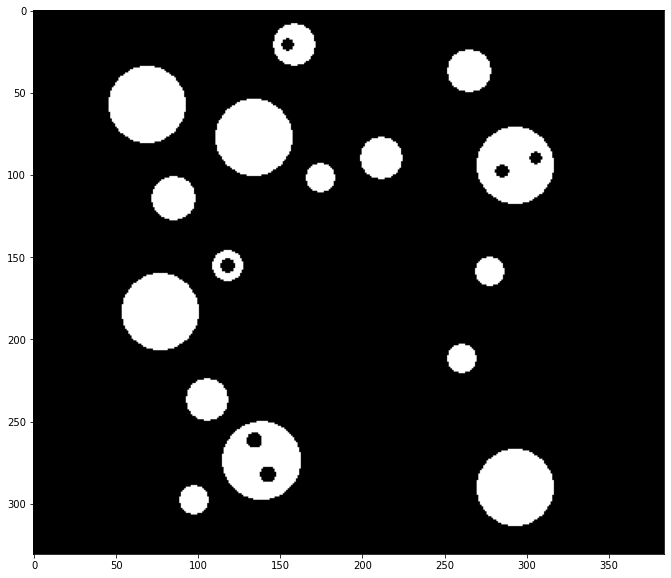

In [14]:
circles = objects-squares
plt.figure(figsize=(12,10))
plt.imshow(circles,cmap='gray')
plt.show()

In [15]:
circle_components = ccl_2_pass(circles)
count,hole_circles = get_object_with_holes(circle_components)
print("Circles with holes :",count)

Circles with holes : 4


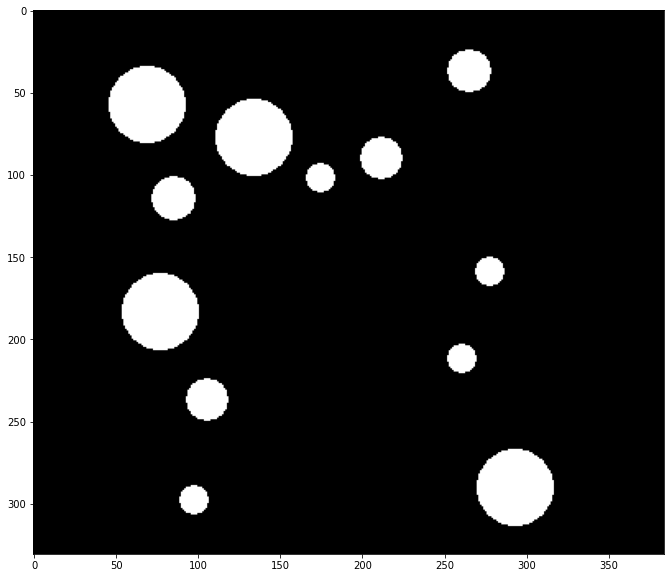

In [16]:
plt.figure(figsize=(12,10))
plt.imshow(circles-hole_circles,cmap='gray')
plt.show()

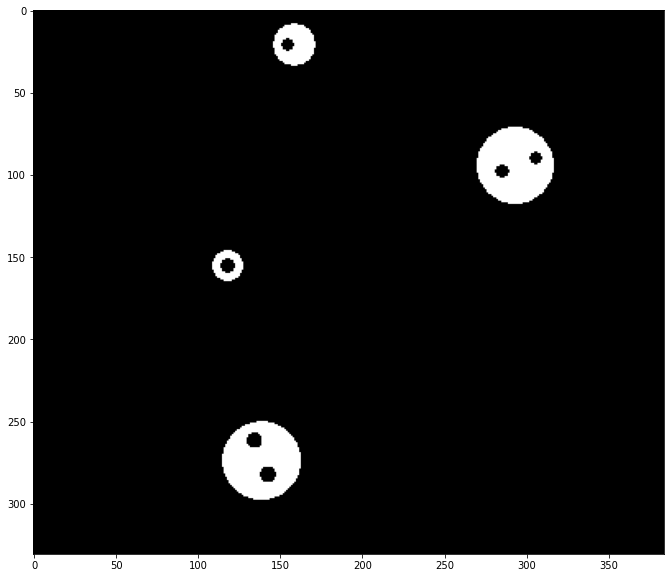

In [17]:
plt.figure(figsize=(12,10))
plt.imshow(hole_circles,cmap='gray')
plt.show()